In [192]:
import numpy as np
import requests
import pandas as pd
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
import seaborn as sns
cv = CountVectorizer()
# nltk.download("stopwords")
# nltk.download('punkt')
stop_words = set(stopwords.words("english"))

stop_words.add('also')
stop_words.add('understand')
stop_words.add('end')
stop_words.add('youll')
stop_words.add('well')
stop_words.add('include')
stop_words.add('time')
stop_words.add('goal')
stop_words.add('path')
stop_words.add('total')
stop_words.add('go')
stop_words.add('students')
stop_words.add('use')
stop_words.add('using')
stop_words.add('new')
stop_words.add('job')
stop_words.add('term')
stop_words.add('find')
stop_words.add('example')
stop_words.add('non')
stop_words.add('finally')
stop_words.add('times')
stop_words.add('learn')
stop_words.add('two')
stop_words.add('field')
stop_words.add('tools')
stop_words.add('often')
stop_words.add('use')
stop_words.add('tip')
stop_words.add('next')

In [193]:
url = 'http://localhost:4000/graphql'

# Data collection
Get all the modules in the DB and convert it to a dataframe

In [194]:
# moduleData = requests.post(url, json={'query': '{ module(input:{}){id, name, prefix, hours, objectives, description, keywords} }'}).json()

# load module data from json file
import json
with open('input/603_gpt.json') as json_file:
    moduleData = json.load(json_file)

# MODULE_COUNT = len(moduleData.get('data').get('module'))
MODULE_COUNT = len(moduleData)
CLUSTER_COUNT = np.sqrt(MODULE_COUNT)
# CLUSTER_COUNT = 37

In [195]:
# moduleDF = pd.DataFrame(moduleData.get('data').get('module'))
moduleDF = pd.DataFrame(moduleData)

moduleDF.head()

,id,name,prefix,number,objectives,hours,description,keywords
0,644827afc3faa4c9ea96a800,Linear Regression,DS,72,"[Linear Regression, Correlation, Regression An...",0.75,This module is designed to introduce students ...,"[Linear regression, Statistical technique, Mod..."
1,64496079d5fb014e40d5ea39,Statistical Analysis,DS,9,"[Statistical Analysis, Descriptive Statistics,...",1.50,This module is designed to teach students the ...,"[Statistical Analysis, Data Collection, Data O..."
2,644960add5fb014e40d5ea3a,Logarithms,DS,121,"[Logarithms, Exponential Functions, Logarithmi...",2.00,This module is designed to introduce students ...,"[Logarithms, Exponential equations, Problem-so..."
3,644960bcd5fb014e40d5ea3b,Arithmetics,DS,2,"[Arithmetic, Operations, Addition, Subtraction...",0.50,This module is designed to teach students the ...,"[Arithmetic, Whole Number Operations, Fraction..."
4,64496111d5fb014e40d5ea3c,Euclidean distance,DS,887,"[Euclidean Distance, Distance Formula, Pythago...",2.25,"In this module, we'll be learning about the Eu...","[Euclidean Distance, Mathematics, Computer Sci..."


# Verifying the sparsity of the dataset

Since we have a lot of modules without a description, the results will be skewed towards the modules with a description or just overall more text content. In future works, it might be optimal to use a generative model to generate a description for the modules without one using the context clues from other features.

In [196]:
moduleDF[moduleDF['description'] == '']

,id,name,prefix,number,objectives,hours,description,keywords


# Data cleaning and Feature engineering

Merge all the text content into a single column for each module. This is an essential step to be able to perform the text analysis and text vectorization on the data

In [197]:
def scalar_to_str(df):
    lst_o = list(df['objectives'])
    lst_k = list(df['keywords'])

    string_obj_feature = ''
    string_key_feature = ''

    for obj in lst_o:
        string_obj_feature += obj + ', '

    for key in lst_k:
        string_key_feature += key + ', '

    df['objectives'] = string_obj_feature
    df['keywords'] = string_key_feature
    return df

moduleDF = moduleDF.apply(scalar_to_str, axis=1)

In [198]:
moduleDF['feature'] = moduleDF['name'] + ', ' + moduleDF['objectives'] + ', ' + moduleDF['description'] + ', ' + moduleDF['keywords'] + ', ' + moduleDF['prefix']

moduleDF.drop(['name', 'objectives', 'description', 'keywords', 'number'], axis=1, inplace=True)

moduleDF.rename(columns={'prefix': 'true_cluster'}, inplace=True)

moduleDF.head()

,id,true_cluster,hours,feature
0,644827afc3faa4c9ea96a800,DS,0.75,"Linear Regression, Linear Regression, Correlat..."
1,64496079d5fb014e40d5ea39,DS,1.50,"Statistical Analysis, Statistical Analysis, De..."
2,644960add5fb014e40d5ea3a,DS,2.00,"Logarithms, Logarithms, Exponential Functions,..."
3,644960bcd5fb014e40d5ea3b,DS,0.50,"Arithmetics, Arithmetic, Operations, Addition,..."
4,64496111d5fb014e40d5ea3c,DS,2.25,"Euclidean distance, Euclidean Distance, Distan..."


In [199]:
def _text_processing(col: pd.DataFrame()):
    """
    This function takes in a column of text and performs the following:
    1. Converts all text to lowercase
    2. Removes all non-alphabetic characters
    3. Removes stop words
    5. returns the column
    """
    column = col.str.lower()
    column = column.str.replace("[^a-z ]", "")

    word_tokens = column.str.split()
    keys = word_tokens.apply(
        lambda x: [item for item in x if item not in stop_words]
    )
    for j in range(len(keys)):
        keys[j] = " ".join(keys[j])
        column = keys
    return column

In [200]:
moduleDF['cleaned_feature'] = _text_processing(moduleDF['feature'])

/var/folders/tp/4mcknzvj6zj5kcx78g7f5nmw0000gp/T/ipykernel_16930/630142521.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  column = column.str.replace("[^a-z ]", "")


In [201]:
def get_tokens(text):
    ps = PorterStemmer()
    payload = ""

    tokens = word_tokenize(text)

    tokens = [t for t in tokens if not t in stop_words]

    for t in range(len(tokens)):
        tokens[t] = ps.stem(tokens[t])

    for token in tokens:
        payload += token + ' '

    return payload

In [202]:
moduleDF['tokens'] = moduleDF['cleaned_feature'].apply(lambda x: get_tokens(x))

moduleDF.drop(['feature', 'cleaned_feature'], axis=1, inplace=True)

moduleDF.head(20)

,id,true_cluster,hours,tokens
0,644827afc3faa4c9ea96a800,DS,0.750,linear regress linear regress correl regress a...
1,64496079d5fb014e40d5ea39,DS,1.500,statist analysi statist analysi descript stati...
2,644960add5fb014e40d5ea3a,DS,2.000,logarithm logarithm exponenti function logarit...
3,644960bcd5fb014e40d5ea3b,DS,0.500,arithmet arithmet oper addit subtract multipl ...
4,64496111d5fb014e40d5ea3c,DS,2.250,euclidean distanc euclidean distanc distanc fo...
5,64511f49f9ce74323575fffe,CSLP,0.300,introduct linear program model comput implemen...
6,64511f4bf9ce74323575ffff,CSLP,0.300,comput solut lp formul linear program comput s...
7,646270b939769687f2a6d858,LP-ME,0.300,linear program model linear program model line...
8,646273ce39769687f2a6d860,TP,0.700,transport transport transport introduct transp...
9,646273e539769687f2a6d861,TP,0.730,transship transship transship introduct transs...


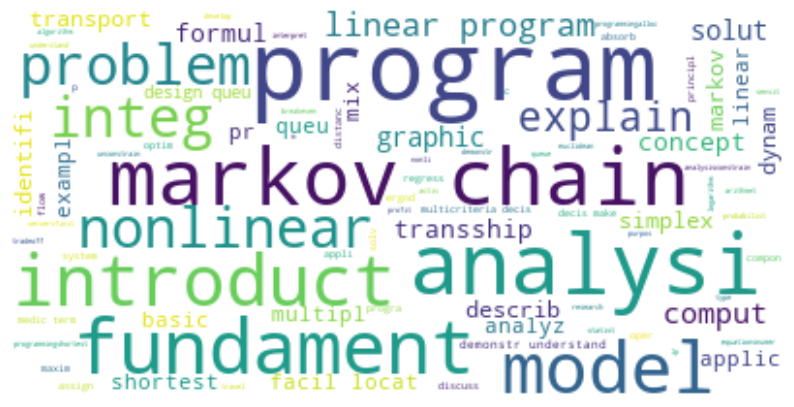

In [203]:
from wordcloud import WordCloud

def generate_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

generate_word_cloud(moduleDF['tokens'].to_string())

In [204]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

moduleDF['true_cluster'] = le.fit_transform(moduleDF['true_cluster'])

moduleDF.head(20)

,id,true_cluster,hours,tokens
0,644827afc3faa4c9ea96a800,4,0.750,linear regress linear regress correl regress a...
1,64496079d5fb014e40d5ea39,4,1.500,statist analysi statist analysi descript stati...
2,644960add5fb014e40d5ea3a,4,2.000,logarithm logarithm exponenti function logarit...
3,644960bcd5fb014e40d5ea3b,4,0.500,arithmet arithmet oper addit subtract multipl ...
4,64496111d5fb014e40d5ea3c,4,2.250,euclidean distanc euclidean distanc distanc fo...
5,64511f49f9ce74323575fffe,2,0.300,introduct linear program model comput implemen...
6,64511f4bf9ce74323575ffff,2,0.300,comput solut lp formul linear program comput s...
7,646270b939769687f2a6d858,11,0.300,linear program model linear program model line...
8,646273ce39769687f2a6d860,20,0.700,transport transport transport introduct transp...
9,646273e539769687f2a6d861,20,0.730,transship transship transship introduct transs...


# Modeling

In [205]:
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer()

moduleDF['cluster'] = 0

X = vectorizer.fit_transform(moduleDF['tokens'])
Y = moduleDF['cluster']

kmeans = KMeans(n_clusters=int(CLUSTER_COUNT), random_state=42, n_init=100, max_iter=1000).fit(X)

moduleDF['cluster'] = kmeans.predict(X)

moduleDF.head()

,id,true_cluster,hours,tokens,cluster
0,644827afc3faa4c9ea96a800,4,0.75,linear regress linear regress correl regress a...,2
1,64496079d5fb014e40d5ea39,4,1.50,statist analysi statist analysi descript stati...,2
2,644960add5fb014e40d5ea3a,4,2.00,logarithm logarithm exponenti function logarit...,2
3,644960bcd5fb014e40d5ea3b,4,0.50,arithmet arithmet oper addit subtract multipl ...,2
4,64496111d5fb014e40d5ea3c,4,2.25,euclidean distanc euclidean distanc distanc fo...,4


In [206]:
from sklearn.decomposition import PCA

pca = PCA(n_components=int(CLUSTER_COUNT) // 2, random_state=42)

reduced_features = pca.fit_transform(X.toarray())

x0 = reduced_features[:, 0]
x1 = reduced_features[:, 1]

moduleDF['x0'] = x0
moduleDF['x1'] = x1

In [207]:
def get_top_keywords(n_terms, data = moduleDF['cluster']):
    """This function returns the keywords for each centroid of the KMeans"""
    df = pd.DataFrame(X.todense()).groupby(data).mean() # groups the TF-IDF vector by cluster
    terms = vectorizer.get_feature_names_out() # access tf-idf terms
    for k,r in df.iterrows():
        print('\nCluster {}'.format(k))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score

    termsDF = pd.DataFrame()
    for k,r in df.iterrows():
        termsDF['Cluster {}'.format(k)] = [terms[t] for t in np.argsort(r)[-n_terms:]]
    return termsDF


get_top_keywords(10)


Cluster 0
predict,process,transit,probabl,state,system,ergod,absorb,chain,markov

Cluster 1
sensit,solv,solut,program,model,method,linear,problem,simplex,lp

Cluster 2
statist,regress,problem,network,sensit,facil,locat,flow,analysi,model

Cluster 3
simplex,solv,interpret,solut,model,object,graphic,problem,linear,program

Cluster 4
alloc,program,distanc,project,algorithm,medic,assign,problem,shortest,dynam

Cluster 5
solv,mix,equat,make,profit,decis,numer,optim,program,nonlinear

Cluster 6
algorithm,solv,comput,techniqu,select,set,solut,problem,program,integ

Cluster 7
concept,strategi,work,advantag,conclus,reallif,economi,global,busi,transship

Cluster 8
finit,multipl,custom,design,perform,servic,server,queue,system,queu


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7,Cluster 8
0,predict,sensit,statist,simplex,alloc,solv,algorithm,concept,finit
1,process,solv,regress,solv,program,mix,solv,strategi,multipl
2,transit,solut,problem,interpret,distanc,equat,comput,work,custom
3,probabl,program,network,solut,project,make,techniqu,advantag,design
4,state,model,sensit,model,algorithm,profit,select,conclus,perform
5,system,method,facil,object,medic,decis,set,reallif,servic
6,ergod,linear,locat,graphic,assign,numer,solut,economi,server
7,absorb,problem,flow,problem,problem,optim,problem,global,queue
8,chain,simplex,analysi,linear,shortest,program,program,busi,system
9,markov,lp,model,program,dynam,nonlinear,integ,transship,queu


In [208]:
moduleDF.head(20)

,id,true_cluster,hours,tokens,cluster,x0,x1
0,644827afc3faa4c9ea96a800,4,0.750,linear regress linear regress correl regress a...,2,0.057503,-0.154762
1,64496079d5fb014e40d5ea39,4,1.500,statist analysi statist analysi descript stati...,2,0.139221,-0.239507
2,644960add5fb014e40d5ea3a,4,2.000,logarithm logarithm exponenti function logarit...,2,0.096230,-0.161873
3,644960bcd5fb014e40d5ea3b,4,0.500,arithmet arithmet oper addit subtract multipl ...,2,0.089890,-0.167647
4,64496111d5fb014e40d5ea3c,4,2.250,euclidean distanc euclidean distanc distanc fo...,4,0.120797,-0.177824
5,64511f49f9ce74323575fffe,2,0.300,introduct linear program model comput implemen...,2,-0.041930,-0.155656
6,64511f4bf9ce74323575ffff,2,0.300,comput solut lp formul linear program comput s...,1,-0.196230,-0.040827
7,646270b939769687f2a6d858,11,0.300,linear program model linear program model line...,3,-0.350917,0.232248
8,646273ce39769687f2a6d860,20,0.700,transport transport transport introduct transp...,2,0.096971,-0.172967
9,646273e539769687f2a6d861,20,0.730,transship transship transship introduct transs...,7,0.121585,-0.213435


<AxesSubplot:title={'center':'TF-IDF + Ground Truth clustering'}, xlabel='X0', ylabel='x1'>

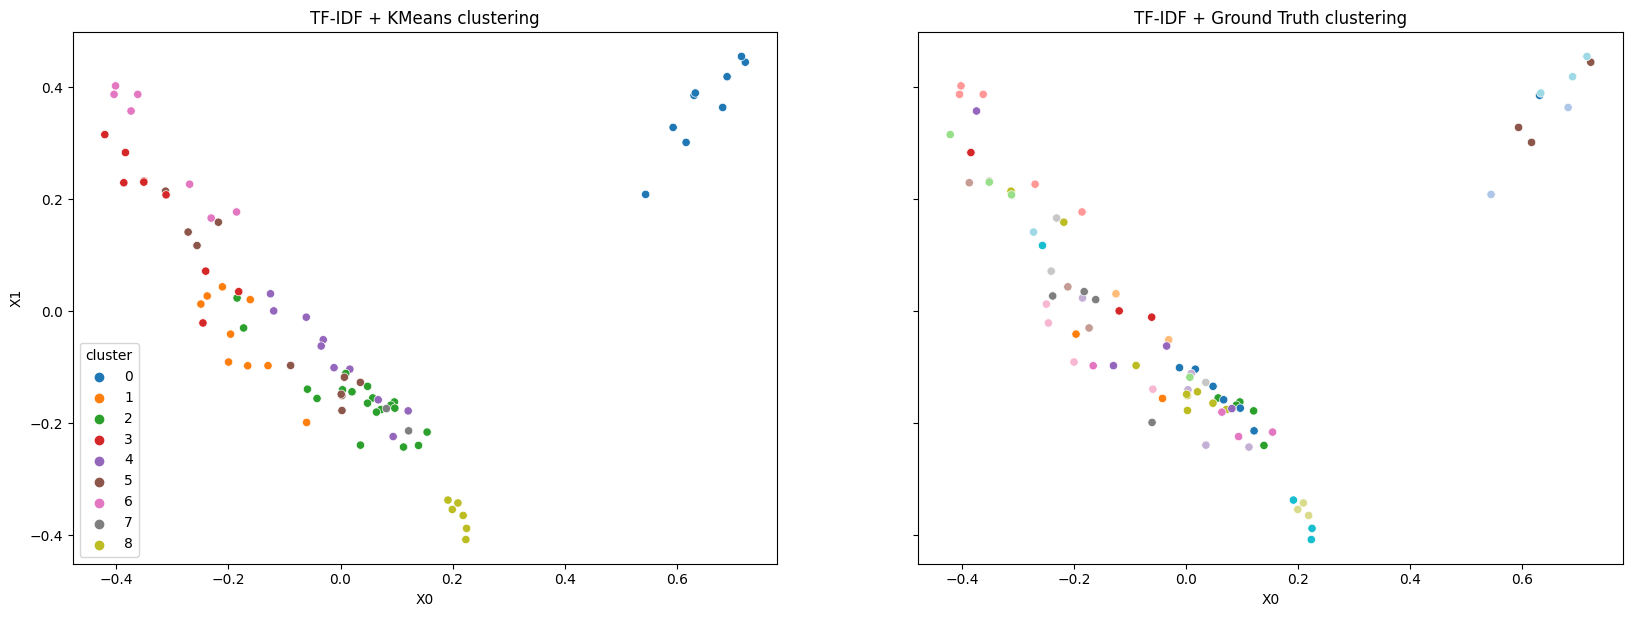

In [227]:
fig, axs = plt.subplots(1, 2, figsize=(20, 14))
for ax in axs.flat:
    ax.set(xlabel='X0', ylabel='X1')
    ax.label_outer()
    ax.set_aspect(1)

axs[0].set_title('TF-IDF + KMeans clustering')
axs[1].set_title('TF-IDF + Ground Truth clustering')

sns.scatterplot(data=moduleDF, x='x0', y='x1', hue='cluster', palette="tab10", ax=axs[0])
sns.scatterplot(data=moduleDF, x='x0', y='x1', hue='true_cluster', palette="tab20", ax=axs[1], legend=False)

In [210]:
# sum the number of hours for each cluster
moduleDF.groupby('cluster')['hours'].sum().sort_values(ascending=False)

cluster
2    19.844402
4    11.538752
0    10.812385
3    10.307585
5     9.414316
1     9.005588
6     8.451804
8     4.783075
7     1.444769
Name: hours, dtype: float64

<AxesSubplot:title={'center':'ENMA 603 - Total Hours and Module count per Cluster'}, xlabel='Cluster', ylabel='Hours & Count'>

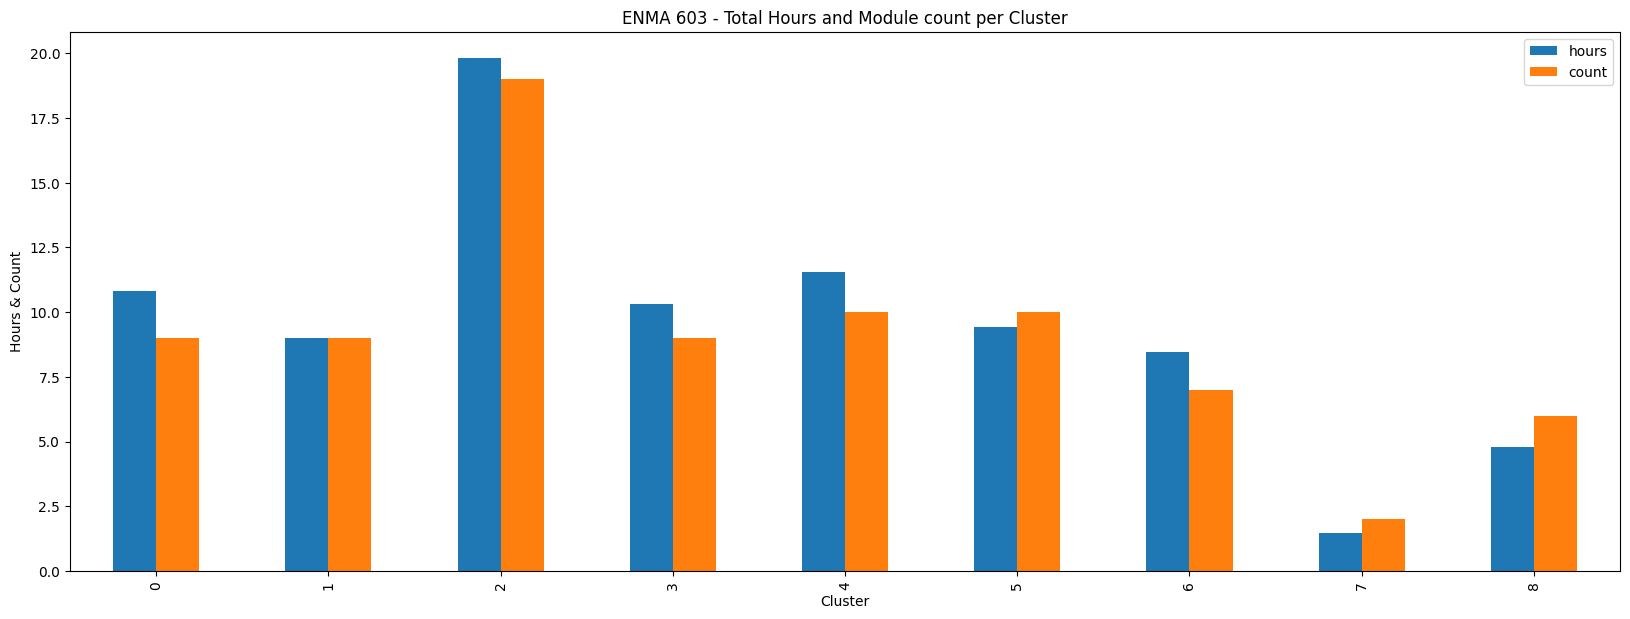

In [211]:
pd.concat(
    [
        moduleDF.groupby('cluster')['hours'].sum().rename('hours'),
        moduleDF.groupby('cluster')['id'].count().rename('count')
    ],
    axis=1
).plot(kind='bar', figsize=(20, 7), title='ENMA 603 - Total Hours and Module count per Cluster', xlabel='Cluster', ylabel='Hours & Count', legend=['Hours', 'Count'])

array([[<AxesSubplot:title={'center':'hours'}>]], dtype=object)

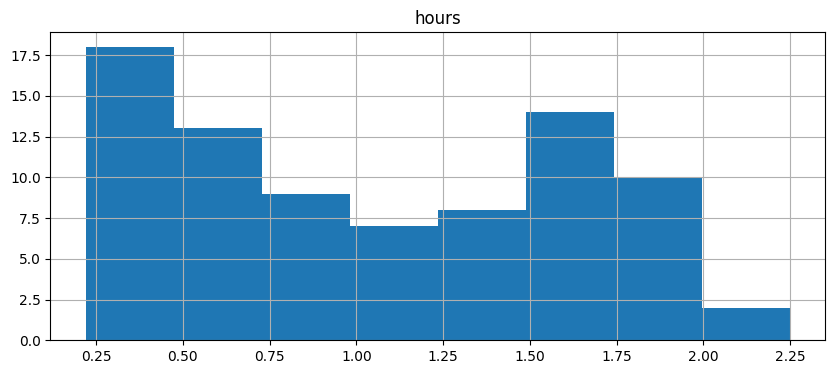

In [212]:
moduleDF.hist(figsize=(10, 4), bins=8, column='hours')

# Evaluating the model

In [213]:
from sklearn.metrics import silhouette_score

silhouette_score(X, moduleDF['cluster'])

0.11160445339425283

In [214]:
# create new dataframe with test data and evaluate the model
testDF = pd.read_csv('input/614_num.tsv', sep='\t')

testDF.head()

,name,prefix,features,hours,cluster
0,"Course Introduction, History, and Tools for Co...",INT,Welcome to the Quality System Controls course!...,0.32,1
1,"Variation, Normal Distribution, Sampling, Popu...",MATH,"In this module, we will explore the fundamenta...",2.08,2
2,Control Charts for Variables,CC,"In this module, we will dive into the variable...",1.87,3
3,"Start, Interpret X and R Control Charts, Trial...",CC,"In this module, we will begin our journey into...",0.98,3
4,"Rational Subgroups, Process Capability Assessment",MATH,"In this module, we will explore the importance...",1.48,2


In [215]:
testDF['cleaned_feature'] = _text_processing(testDF['features'])

testDF['tokens'] = testDF['cleaned_feature'].apply(lambda x: get_tokens(x))

testDF.drop(['features', 'cleaned_feature', 'cluster'], axis=1, inplace=True)

testDF.head()

/var/folders/tp/4mcknzvj6zj5kcx78g7f5nmw0000gp/T/ipykernel_16930/630142521.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  column = column.str.replace("[^a-z ]", "")


,name,prefix,hours,tokens
0,"Course Introduction, History, and Tools for Co...",INT,0.32,welcom qualiti system control cours throughout...
1,"Variation, Normal Distribution, Sampling, Popu...",MATH,2.08,modul explor fundament concept variat normal d...
2,Control Charts for Variables,CC,1.87,modul dive variabl control chart control limit...
3,"Start, Interpret X and R Control Charts, Trial...",CC,0.98,modul begin journey world control chart focus ...
4,"Rational Subgroups, Process Capability Assessment",MATH,1.48,modul explor import ration subgroup control ch...


In [216]:
get_top_keywords(10, testDF['prefix'])


Cluster CC
whole,math,oper,fraction,decim,percentag,number,exponenti,arithmet,logarithm

Cluster CTR
post,graphic,simplex,uncertainti,model,analysi,sensit,method,lp,comput

Cluster DA
mathemat,solv,main,begin,maxim,model,minim,problem,program,linear

Cluster INT
techniqu,variabl,scienc,build,relationship,model,predict,statist,linear,regress

Cluster MATH
test,theorem,vector,space,scienc,data,analysi,euclidean,statist,distanc

Cluster Q
environment,form,train,boat,buse,car,reallif,economi,transport,transship


,Cluster CC,Cluster CTR,Cluster DA,Cluster INT,Cluster MATH,Cluster Q
0,whole,post,mathemat,techniqu,test,environment
1,math,graphic,solv,variabl,theorem,form
2,oper,simplex,main,scienc,vector,train
3,fraction,uncertainti,begin,build,space,boat
4,decim,model,maxim,relationship,scienc,buse
5,percentag,analysi,model,model,data,car
6,number,sensit,minim,predict,analysi,reallif
7,exponenti,method,problem,statist,euclidean,economi
8,arithmet,lp,program,linear,statist,transport
9,logarithm,comput,linear,regress,distanc,transship


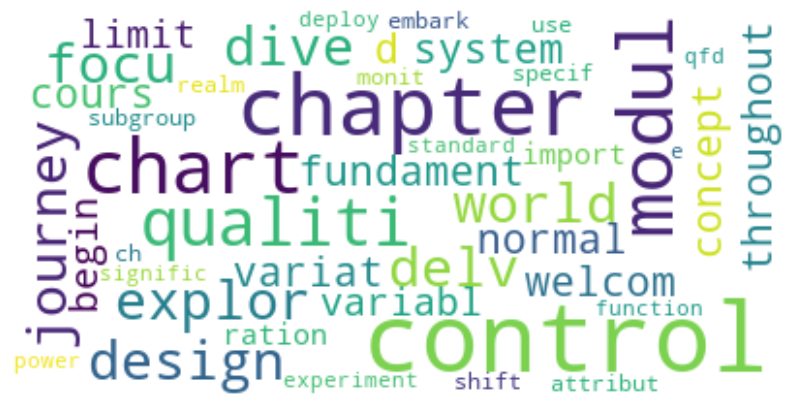

In [217]:
generate_word_cloud(testDF['tokens'].to_string())

In [218]:
X_test = vectorizer.transform(testDF['tokens'])

testDF['cluster'] = kmeans.predict(X_test)

testDF.head(20)

,name,prefix,hours,tokens,cluster
0,"Course Introduction, History, and Tools for Co...",INT,0.32,welcom qualiti system control cours throughout...,2
1,"Variation, Normal Distribution, Sampling, Popu...",MATH,2.08,modul explor fundament concept variat normal d...,2
2,Control Charts for Variables,CC,1.87,modul dive variabl control chart control limit...,2
3,"Start, Interpret X and R Control Charts, Trial...",CC,0.98,modul begin journey world control chart focus ...,2
4,"Rational Subgroups, Process Capability Assessment",MATH,1.48,modul explor import ration subgroup control ch...,2
5,Statistics for Control Charts for Attributes,CTR,0.35,chapter shift focu control chart attribut use ...,2
6,Control Charts for Fraction Defective,CTR,0.62,chapter delv control chart specif design monit...,2
7,Design and Analysis of Experiments,DA,1.97,chapter embark journey realm experiment design...,2
8,Quality Standards,Q,0.35,chapter delv world qualiti standard signific e...,2
9,Quality Function Deployment,Q,1.04,chapter dive qualiti function deploy qfd power...,2


# Exporting to JSON

In [219]:
import uuid

# create a json list of objects from the moduleDF where each module is grouped by the cluster number.
# The result should be a list of collection objects with a modules key that is representative of the cluster's modules

# create a list of clusters
clusters = moduleDF['cluster'].unique().tolist()

# create a list of modules
modules = moduleDF['id'].unique().tolist()

jsonList = []

for cluster in clusters:
    jsonList.append({
        'id': uuid.uuid4().hex,
        'number': cluster,
        'modules': [
             # create a list of objects for each module in the cluster with a single key of id
            {
                'id': module
            } for module in modules if moduleDF.loc[moduleDF['id'] == module, 'cluster'].iloc[0] == cluster
        ]
    })

payload = {
    "collections": sorted(jsonList, key=lambda x: x['number'])
}

json_payload = json.dumps(payload, indent=2)

print(json_payload)

{
  "collections": [
    {
      "id": "6ab6cf0735004d0f889d66652ccf4883",
      "number": 0,
      "modules": [
        {
          "id": "64627a0e39769687f2a6d872"
        },
        {
          "id": "64627a2739769687f2a6d873"
        },
        {
          "id": "64627a3b39769687f2a6d874"
        },
        {
          "id": "64627c5239769687f2a6d875"
        },
        {
          "id": "646506f68019c4d441f6ec38"
        },
        {
          "id": "646506f78019c4d441f6ec39"
        },
        {
          "id": "646506f78019c4d441f6ec3a"
        },
        {
          "id": "646506f78019c4d441f6ec3b"
        },
        {
          "id": "646506f78019c4d441f6ec3c"
        }
      ]
    },
    {
      "id": "c95ae2a0ddd24b4883c5bfad9cb5e795",
      "number": 1,
      "modules": [
        {
          "id": "64511f4bf9ce74323575ffff"
        },
        {
          "id": "646506c28019c4d441f6ec0f"
        },
        {
          "id": "646506c38019c4d441f6ec12"
        },
        {
   

In [220]:
# save json payload as json file

with open('enma603.json', 'w') as outfile:
    json.dump(payload, outfile, indent=2)

TODO:
1. Separate the clusters into groups of sections based on the similarity of the modules within the cluster. More similar clusters should be grouped together
2. Map the created sections to existing sections for the given course from the DB
3. Generate a learning path for the single course, it's sections, it's collections, and it's modules
4. Generate learning outcomes for the course, based on the sections that are mapped to the course
5. Aggregate the number of hours for the entire path and add the value to the hours satisfies property in the final path json object


In [221]:
# calculate the similarity between each collection

from sklearn.metrics.pairwise import cosine_similarity

cluster_similarity_df = pd.DataFrame(columns=clusters, index=clusters)

for cluster in clusters:
    for cluster2 in clusters:
        cluster_similarity_df.loc[cluster, cluster2] = cosine_similarity(
            np.asarray(X[moduleDF.loc[moduleDF['cluster'] == cluster].index.tolist()].mean(axis=0)),
            np.asarray(X[moduleDF.loc[moduleDF['cluster'] == cluster2].index.tolist()].mean(axis=0))
        )[0][0]

cluster_similarity_df = cluster_similarity_df.astype(float)

cluster_similarity_df.head(20)

,2,4,1,3,7,5,6,8,0
2,1.000000,0.262580,0.417880,0.435551,0.070842,0.274199,0.272186,0.166550,0.123453
4,0.262580,1.000000,0.225219,0.312652,0.072436,0.187374,0.288460,0.064380,0.056984
1,0.417880,0.225219,1.000000,0.582497,0.042266,0.246996,0.310326,0.064578,0.069159
3,0.435551,0.312652,0.582497,1.000000,0.059885,0.379217,0.576806,0.072655,0.068441
7,0.070842,0.072436,0.042266,0.059885,1.000000,0.046001,0.051854,0.034702,0.025795
5,0.274199,0.187374,0.246996,0.379217,0.046001,1.000000,0.325355,0.062507,0.062940
6,0.272186,0.288460,0.310326,0.576806,0.051854,0.325355,1.000000,0.053846,0.049148
8,0.166550,0.064380,0.064578,0.072655,0.034702,0.062507,0.053846,1.000000,0.107547
0,0.123453,0.056984,0.069159,0.068441,0.025795,0.062940,0.049148,0.107547,1.000000


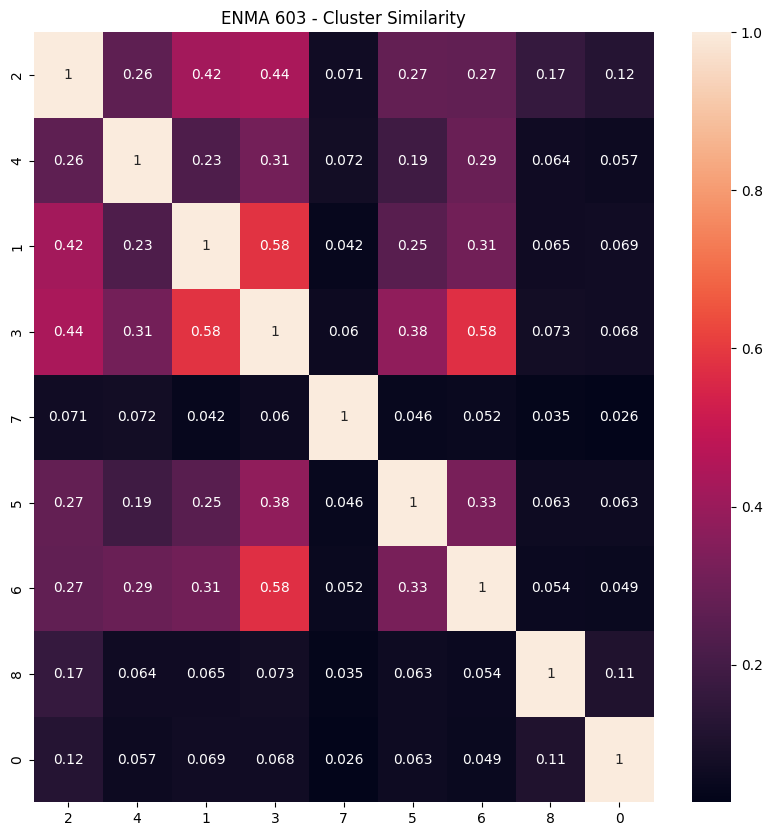

In [222]:
# visualize the similarity between clusters

fig, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(cluster_similarity_df, annot=True, ax=ax)

ax.set_title('ENMA 603 - Cluster Similarity')

plt.show()

From the heatmap we can see that
- clusters 3, 6 and 1 are the most similar to each other
- clusters 2, 4 and 5 are somewhat similar to each other
- clusters 0, 7 and 8 are the least similar to every other cluster, so they should be seperated into their own sections

In [223]:
# create a list of sections based on the similarity of the clusters
# each cluster should only be in a single section
# the sections should be a list of clusters

sections = []

for cluster in clusters:
    if cluster not in [item for sublist in sections for item in sublist]:
        sections.append([cluster])

    for cluster2 in clusters:
        if cluster != cluster2 and cluster_similarity_df.loc[cluster, cluster2] > 0.3:
            for section in sections:
                if cluster in section and cluster2 not in section:
                    section.append(cluster2)
                    break
                else:
                    if cluster not in [item for sublist in sections for item in sublist]:
                        sections.append([cluster])
                    if cluster2 not in [item for sublist in sections for item in sublist]:
                        sections.append([cluster2])

sections

[[2, 1, 3, 6, 4, 5], [4, 3, 2, 1, 6, 5], [7], [8], [0]]

In [224]:
# convert the sections list to a json object with its list of clusters and each clusters list of modules
# TODO: filter out duplicate clusters from the sections list before converting to json

jsonList = []

for section in sections:
    jsonList.append({
        'id': uuid.uuid4().hex,
        'number': sections.index(section),
        'collections': [
            {
                'id': uuid.uuid4().hex,
                'cluster': cluster,
                'modules': [
                    {
                        'id': module
                    } for module in modules if moduleDF.loc[moduleDF['id'] == module, 'cluster'].iloc[0] == cluster
                ]
            } for cluster in section
        ]
    })

payload = {
    'id': uuid.uuid4().hex,
    "sections": sorted(jsonList, key=lambda x: x['number'])
}

json_payload = json.dumps(payload, indent=2)

print(json_payload)

{
  "id": "bab976bce16e4d339f00bf94fd92fac9",
  "sections": [
    {
      "id": "ca5c7428c4164d43a0536a60d17f6212",
      "number": 0,
      "collections": [
        {
          "id": "21d5b06a471f4a77919fff5d166376c2",
          "cluster": 2,
          "modules": [
            {
              "id": "644827afc3faa4c9ea96a800"
            },
            {
              "id": "64496079d5fb014e40d5ea39"
            },
            {
              "id": "644960add5fb014e40d5ea3a"
            },
            {
              "id": "644960bcd5fb014e40d5ea3b"
            },
            {
              "id": "64511f49f9ce74323575fffe"
            },
            {
              "id": "646273ce39769687f2a6d860"
            },
            {
              "id": "6462747b39769687f2a6d864"
            },
            {
              "id": "646274e939769687f2a6d867"
            },
            {
              "id": "646506c28019c4d441f6ec0a"
            },
            {
              "id": "646506c28019c4

In [225]:
# save json payload as json file

with open('enma603_sections.json', 'w') as outfile:
    json.dump(payload, outfile, indent=2)